<a href="https://colab.research.google.com/github/msvt37/CaseStudy/blob/main/Project2-060621.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Evaluation of Multiple Trading Strategies for a single equity (LUV).  

The code below is a collection of strategies against the ticker (LUV) or Southwest airlines.  

In [1]:
import pandas as pd
import keras
import pandas.plotting
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from pylab import mpl, plt
plt.style.use('seaborn')

In [5]:
!pip install yfinance
import yfinance as yf

In [6]:
#Defines the ticker symbols and dates to pull data for
symbols = ['LUV']
start = '2001-01-01'
end = '2021-06-03'

In [7]:
#create the DF and pull in only the Adjusted Close for specified ticker
df = pd.DataFrame()
for s in symbols:
    df[s] = yf.download(s,start,end)['Adj Close']

[*********************100%***********************]  1 of 1 completed


In [8]:
#Column does not have a name, so name it
df.rename(columns={ df.columns[0] : 'Adj Close'}, inplace=True)

Momentum Trading Strategy #1


In [15]:
def MomStrat(returns, period=1, shorts=False):
    if shorts:
        position = returns.rolling(period).mean().map(
            lambda x: -1 if x <= 0 else 1)
    else:
        position = returns.rolling(period).mean().map(
            lambda x: 0 if x <= 0 else 1)
    performance = position.shift(1) * returns
    return performance

In [16]:
mom_returns = np.log(df['Adj Close'] / df['Adj Close'].shift(1)).dropna()

In [19]:
performance = MomStrat(mom_returns, period=1, shorts=False).dropna()
years = (performance.index.max() - performance.index.min()).days / 365
perf_cum = np.exp(performance.cumsum())
tot = perf_cum[-1] - 1
ann = perf_cum[-1] ** (1 / years) - 1
vol = performance.std() * np.sqrt(252)
rfr = 0.02
sharpe = (ann - rfr) / vol
print(f"1-day TSM Strategy yields:" +
      f"\n\t{tot*100:.2f}% total returns" + 
      f"\n\t{ann*100:.2f}% annual returns" +
      f"\n\t{sharpe:.2f} Sharpe Ratio")
gme_ret = np.exp(mom_returns.cumsum())
b_tot = gme_ret[-1] - 1
b_ann = gme_ret[-1] ** (1 / years) - 1
b_vol = mom_returns.std() * np.sqrt(252)
b_sharpe = (b_ann - rfr) / b_vol
print(f"Baseline Buy-and-Hold Strategy yields:" + 
      f"\n\t{b_tot*100:.2f}% total returns" + 
      f"\n\t{b_ann*100:.2f}% annual returns" +
      f"\n\t{b_sharpe:.2f} Sharpe Ratio")

1-day TSM Strategy yields:
	-65.30% total returns
	-5.05% annual returns
	-0.28 Sharpe Ratio
Baseline Buy-and-Hold Strategy yields:
	198.22% total returns
	5.50% annual returns
	0.10 Sharpe Ratio


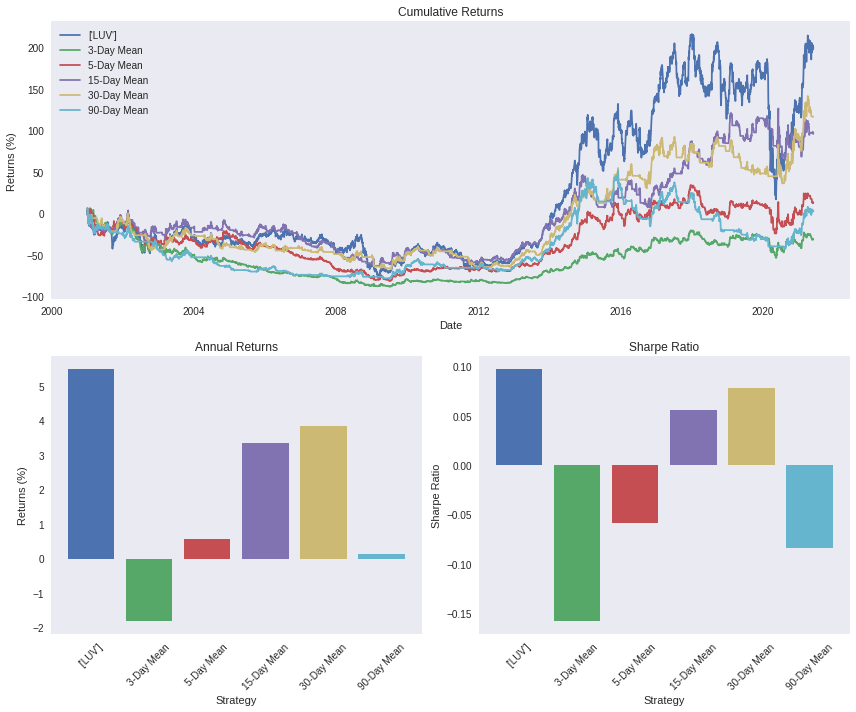

In [24]:
import matplotlib.gridspec as gridspec
periods = [3, 5, 15, 30, 90]
fig = plt.figure(figsize=(12, 10))
gs = fig.add_gridspec(4, 4)
ax0 = fig.add_subplot(gs[:2, :4])
ax1 = fig.add_subplot(gs[2:, :2])
ax2 = fig.add_subplot(gs[2:, 2:])
ax0.plot((np.exp(mom_returns.cumsum()) - 1) * 100, label=symbols, linestyle='-')
perf_dict = {'tot_ret': {'buy_and_hold': (np.exp(mom_returns.sum()) - 1)}}
perf_dict['ann_ret'] = {'buy_and_hold': b_ann}
perf_dict['sharpe'] = {'buy_and_hold': b_sharpe}
for p in periods:
    log_perf = MomStrat(mom_returns, period=p, shorts=False)
    perf = np.exp(log_perf.cumsum())
    perf_dict['tot_ret'][p] = (perf[-1] - 1)
    ann = (perf[-1] ** (1/years) - 1)
    perf_dict['ann_ret'][p] = ann
    vol = log_perf.std() * np.sqrt(252)
    perf_dict['sharpe'][p] = (ann - rfr) / vol
    ax0.plot((perf - 1) * 100, label=f'{p}-Day Mean')
    
ax0.set_ylabel('Returns (%)')
ax0.set_xlabel('Date')
ax0.set_title('Cumulative Returns')
ax0.grid()
ax0.legend()
_ = [ax1.bar(i, v * 100) for i, v in enumerate(perf_dict['ann_ret'].values())]
ax1.set_xticks([i for i, k in enumerate(perf_dict['ann_ret'])])
ax1.set_xticklabels([f'{k}-Day Mean' 
    if type(k) is int else symbols for 
    k in perf_dict['ann_ret'].keys()],
    rotation=45)
ax1.grid()
ax1.set_ylabel('Returns (%)')
ax1.set_xlabel('Strategy')
ax1.set_title('Annual Returns')
_ = [ax2.bar(i, v) for i, v in enumerate(perf_dict['sharpe'].values())]
ax2.set_xticks([i for i, k in enumerate(perf_dict['sharpe'])])
ax2.set_xticklabels([f'{k}-Day Mean' 
    if type(k) is int else symbols for 
    k in perf_dict['sharpe'].keys()],
    rotation=45)
ax2.grid()
ax2.set_ylabel('Sharpe Ratio')
ax2.set_xlabel('Strategy')
ax2.set_title('Sharpe Ratio')
plt.tight_layout()
plt.show()

Momentim Strategy #2

In [25]:
from scipy.stats import linregress
def momentum(closes):
    returns = np.log(closes)
    x = np.arange(len(returns))
    slope, _, rvalue, _, _ = linregress(x, returns)
    return ((1 + slope) ** 252) * (rvalue ** 2)  # annualize slope and multiply by R^2

In [ ]:
momentums = df.copy(deep=True)
for ticker in tickers:
    momentums[ticker] = stocks[ticker].rolling(90).apply(momentum, raw=False)

Simple Moving Averages smooth the price trends and remove noise from the series. When asset prices move over their SMA (cross-over), it may indicate a trading signal.  Using a shorter term MA with a longer term MA is known as a "golden cross".  Investors watch for shorter term to cross above the longer term for their buy signal. When the shorter term crosses under the longer term, it's a sell signal.

In [41]:
# Set the timeframe for the Simple Moving Averages (42 days and 252 days)
SMA1 = 42  
SMA2 = 252

In [42]:
# Create SMA columns and perform the calculations
df['SMA1'] = df['Adj Close'].rolling(SMA1).mean()  
df['SMA2'] = df['Adj Close'].rolling(SMA2).mean()

In [43]:
# Create Bollinger Bands
def bb(data, sma, window):
    std = data.rolling(window = window).std()
    upper_bb = sma + std * 2
    lower_bb = sma - std * 2
    return upper_bb, lower_bb

df['upper_bb'], df['lower_bb'] = bb(df['Adj Close'], df['SMA1'], 20)


In [44]:
df.head()

,Adj Close,SMA1,SMA2,upper_bb,lower_bb
Date,,,,,
2001-01-02,20.411097,NaN,NaN,NaN,NaN
2001-01-03,20.045078,NaN,NaN,NaN,NaN
2001-01-04,21.198009,NaN,NaN,NaN,NaN
2001-01-05,21.289507,NaN,NaN,NaN,NaN
2001-01-08,20.740505,NaN,NaN,NaN,NaN


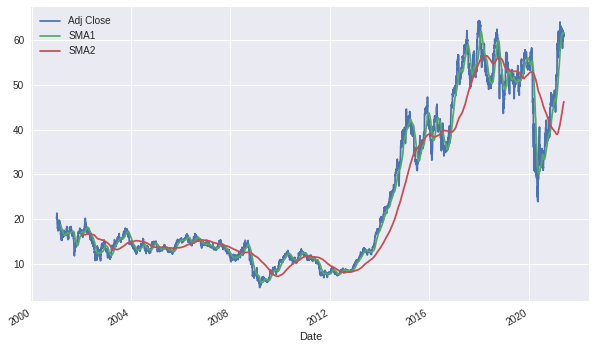

In [9]:
df.plot(figsize=(10, 6))

In [10]:
df.dropna(inplace=True)

In [11]:
# Check where the short term MA is greater than longe term MA, mark those with a 1 and others with -1
df['Position'] = np.where(df['SMA1'] > df['SMA2'], 1, -1)

In [12]:
df.head()

,Adj Close,SMA1,SMA2,Position
Date,,,,
2002-01-07,17.585379,17.019541,16.703195,1
2002-01-08,17.264807,17.055187,16.690709,1
2002-01-09,16.797701,17.069247,16.677823,1
2002-01-10,16.495453,17.077854,16.659162,1
2002-01-11,16.284790,17.092564,16.639302,1


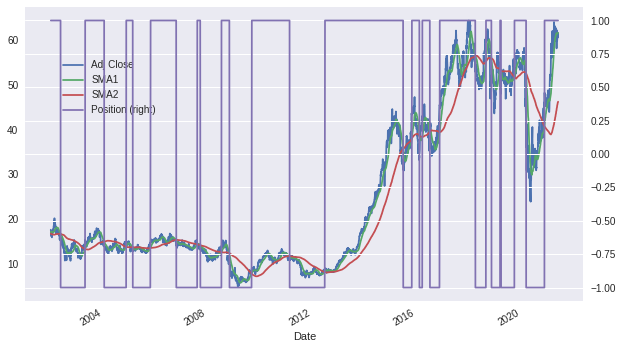

In [13]:
ax = df.plot(secondary_y='Position', figsize=(10, 6))
ax.get_legend().set_bbox_to_anchor((0.25, 0.85))

Backtest the strategy.  Calculate the logs returns and then multiply by the postion.  Performance values show the return with SMA and holding long.

In [14]:
# Calculate the log returns for investment (benchmark)
df['Returns'] = np.log(df['Adj Close'] / df['Adj Close'].shift(1))

In [15]:
#
df['Strategy'] = df['Position'].shift(1) * df['Returns']

In [16]:
df.dropna(inplace=True)

In [17]:
# Sum of returns
np.exp(df[['Returns', 'Strategy']].sum())

Returns     3.461398
Strategy    0.769117
dtype: float64

In [18]:
# Calculate annualized volatility
df[['Returns', 'Strategy']].std() * 252 ** 0.

Returns     0.022206
Strategy    0.022208
dtype: float64

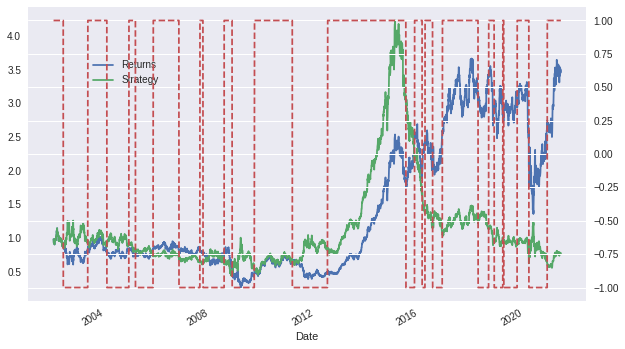

In [19]:
ax = df[['Returns', 'Strategy']].cumsum(
                 ).apply(np.exp).plot(figsize=(10, 6))
df['Position'].plot(ax=ax, secondary_y='Position', style='--')
ax.get_legend().set_bbox_to_anchor((0.25, 0.85))

Linear OLS Regression using two features, lag 1 and lag 2 (two day and one day lags)


In [9]:
# create a copy of the adjusted closing prices in a new dataframe
data2 = df[['Adj Close']].copy()

In [10]:
# Calculate the log returns
data2['Returns'] = np.log(data2 / data2.shift(1))

In [14]:
data2.dropna(inplace=True)

In [12]:
data2.head(15)

,Adj Close,Returns
Date,,
2001-01-02,20.411097,NaN
2001-01-03,20.045078,-0.018095
2001-01-04,21.198009,0.055924
2001-01-05,21.289507,0.004307
2001-01-08,20.740505,-0.026126
2001-01-09,19.532671,-0.060000
2001-01-10,19.489969,-0.002189
2001-01-11,18.818958,-0.035035
2001-01-12,18.709152,-0.005852


In [15]:
# Establish direction of movement
data2['Direction'] = np.sign(data2['Returns']).astype(int)

In [17]:
data2.head()

,Adj Close,Returns,Direction
Date,,,
2001-01-03,20.045078,-0.018095,-1
2001-01-04,21.198009,0.055924,1
2001-01-05,21.289507,0.004307,1
2001-01-08,20.740505,-0.026126,-1
2001-01-09,19.532671,-0.060000,-1


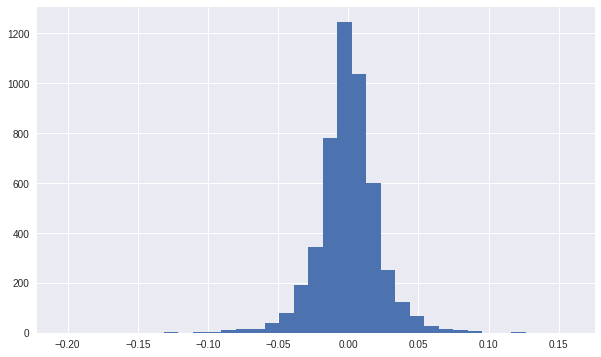

In [24]:
data2['Returns'].hist(bins=35, figsize=(10, 6))

In [20]:
lags = 2

In [21]:
# Function to create the lagged values for features
def create_lags(data):
    global cols
    cols = []
    for lag in range(1, lags + 1):
        col = 'lag_{}'.format(lag)
        data[col] = data['Returns'].shift(lag)
        cols.append(col)

In [22]:
# Call function
create_lags(data2)

In [23]:
data2

,Adj Close,Returns,Direction,lag_1,lag_2
Date,,,,,
2001-01-03,20.045078,-0.018095,-1,NaN,NaN
2001-01-04,21.198009,0.055924,1,-0.018095,NaN
2001-01-05,21.289507,0.004307,1,0.055924,-0.018095
2001-01-08,20.740505,-0.026126,-1,0.004307,0.055924
2001-01-09,19.532671,-0.060000,-1,-0.026126,0.004307
...,...,...,...,...,...
2021-05-26,61.209999,0.010841,1,-0.002145,0.009771
2021-05-27,61.730000,0.008459,1,0.010841,-0.002145
2021-05-28,61.459999,-0.004383,-1,0.008459,0.010841


In [24]:
data2.dropna(inplace=True)

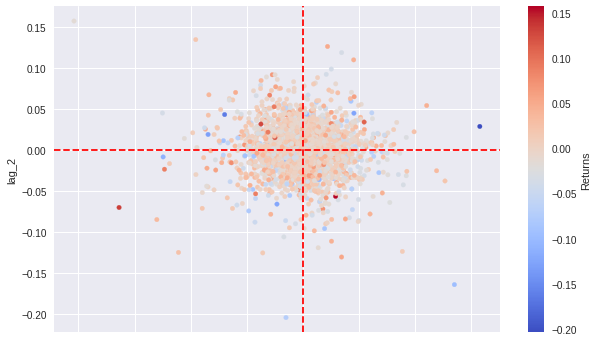

In [29]:
data2.plot.scatter(x='lag_1', y='lag_2', c='Returns', 
                  cmap='coolwarm', figsize=(10, 6), colorbar=True)
plt.axvline(0, c='r', ls='--')
plt.axhline(0, c='r', ls='--')

In [25]:
from sklearn.linear_model import LinearRegression

In [26]:
# Use linear regression model to predict movement 
model = LinearRegression()

In [27]:
data2['pos_ols_1'] = model.fit(data2[cols], data2['Returns']).predict(data2[cols])

data2['pos_ols_2'] = model.fit(data2[cols], data2['Direction']).predict(data2[cols])

In [28]:
data2.head()

,Adj Close,Returns,Direction,lag_1,lag_2,pos_ols_1,pos_ols_2
Date,,,,,,,
2001-01-05,21.289507,0.004307,1,0.055924,-0.018095,-0.003962,-0.145669
2001-01-08,20.740505,-0.026126,-1,0.004307,0.055924,0.001182,0.029976
2001-01-09,19.532671,-0.060000,-1,-0.026126,0.004307,0.002074,0.080402
2001-01-10,19.489969,-0.002189,-1,-0.060000,-0.026126,0.003674,0.151602
2001-01-11,18.818958,-0.035035,-1,-0.002189,-0.060000,-0.000986,-0.017777


In [29]:
data2[['pos_ols_1', 'pos_ols_2']] = np.where(
            data2[['pos_ols_1', 'pos_ols_2']] > 0, 1, -1)

In [30]:
data2['strat_ols_1'] = data2['pos_ols_1'] * data2['Returns']

data2['strat_ols_2'] = data2['pos_ols_2'] * data2['Returns']

In [31]:
data2.head()

,Adj Close,Returns,Direction,lag_1,lag_2,pos_ols_1,pos_ols_2,strat_ols_1,strat_ols_2
Date,,,,,,,,,
2001-01-05,21.289507,0.004307,1,0.055924,-0.018095,-1,-1,-0.004307,-0.004307
2001-01-08,20.740505,-0.026126,-1,0.004307,0.055924,1,1,-0.026126,-0.026126
2001-01-09,19.532671,-0.060000,-1,-0.026126,0.004307,1,1,-0.060000,-0.060000
2001-01-10,19.489969,-0.002189,-1,-0.060000,-0.026126,1,1,-0.002189,-0.002189
2001-01-11,18.818958,-0.035035,-1,-0.002189,-0.060000,-1,-1,0.035035,0.035035


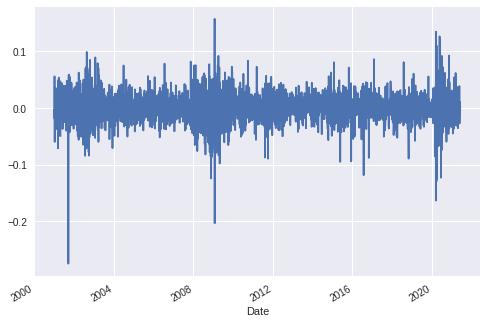

In [39]:
data2['lag_2'].plot()

In [32]:
data2[['Returns', 'strat_ols_1', 'strat_ols_2']].sum().apply(np.exp)

Returns          2.871496
strat_ols_1    200.723634
strat_ols_2    126.811759
dtype: float64

In [33]:
# Count number of correct and false predictions by strategy
(data2['Direction'] == data2['pos_ols_1']).value_counts()

True     2668
False    2465
dtype: int64

In [34]:
(data2['Direction'] == data2['pos_ols_2']).value_counts()

True     2669
False    2464
dtype: int64

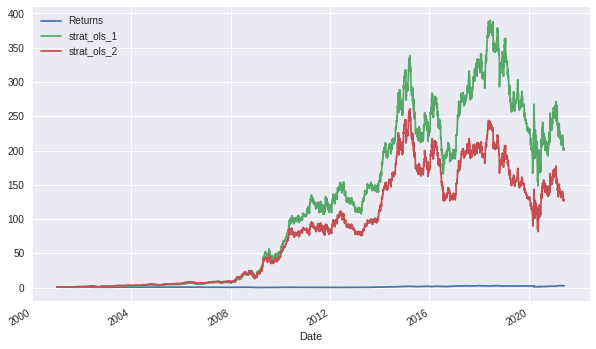

In [35]:
# Performance over time
data2[['Returns', 'strat_ols_1', 'strat_ols_2']].cumsum(
        ).apply(np.exp).plot(figsize=(10, 6))

Facebook Prophet :  The code below is an attempt to use FB prophet for Time Series Forecasting.  (Needs more work and may scrap)

In [47]:
data3 = df[['Adj Close']].copy()

In [48]:
data3.reset_index(inplace=True)

In [49]:
data3

,Date,Adj Close
0,2002-01-08,17.264807
1,2002-01-09,16.797701
2,2002-01-10,16.495453
3,2002-01-11,16.284790
4,2002-01-14,16.174877
...,...,...
4879,2021-05-26,61.209999
4880,2021-05-27,61.730000
4881,2021-05-28,61.459999
4882,2021-06-01,61.349998


In [60]:
data3 = data3.rename(columns={'Date':'ds', 'Adj Close':'y'})

In [61]:
data3.shape

(4884, 2)

In [54]:
df_train = data3[['ds', 'y']].iloc[:2930]
df_predict = data3[['ds']]

In [55]:

from fbprophet import Prophet
# instantiate the model and set parameters
model = Prophet(
 interval_width=0.95,
 growth='linear',
 daily_seasonality=False,
 weekly_seasonality=True,
 yearly_seasonality=True,
 seasonality_mode='multiplicative'
)
# fit the model to historical data
model.fit(df_train)

In [56]:
forecast = model.predict(df_predict)

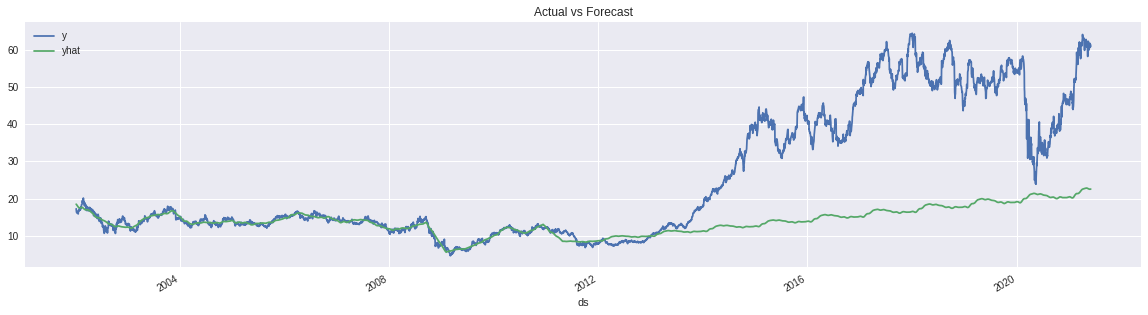

In [57]:
ax = (data3.plot(x='ds',y='y',figsize=(20,5),title='Actual Vs Forecast'))
forecast.plot(x='ds',y='yhat',figsize=(20,5),title='Actual vs Forecast', ax=ax)

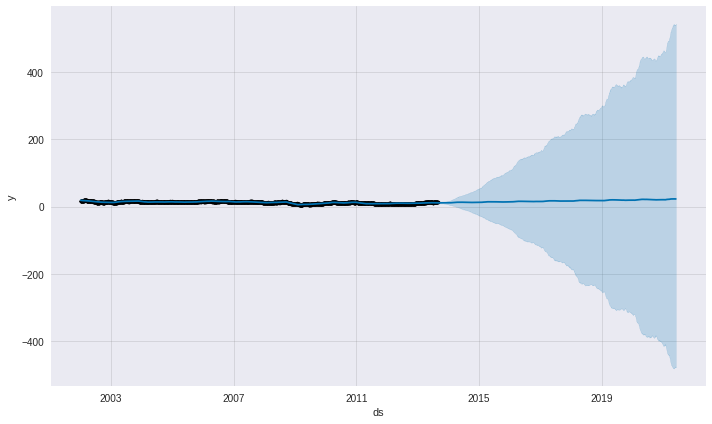

In [68]:
fig1 = model.plot(forecast, uncertainty=True)

In [63]:
model2 = Prophet(
 interval_width=0.95,
 growth='linear',
 daily_seasonality=False,
 weekly_seasonality=True,
 yearly_seasonality=True,
 seasonality_mode='multiplicative'
)
# fit the model to historical data
model2.fit(data3)

In [65]:
future_pd = model2.make_future_dataframe(
 periods=20,
 freq='d',
 include_history=True
)
# predict over the dataset
forecast_pd = model2.predict(future_pd)

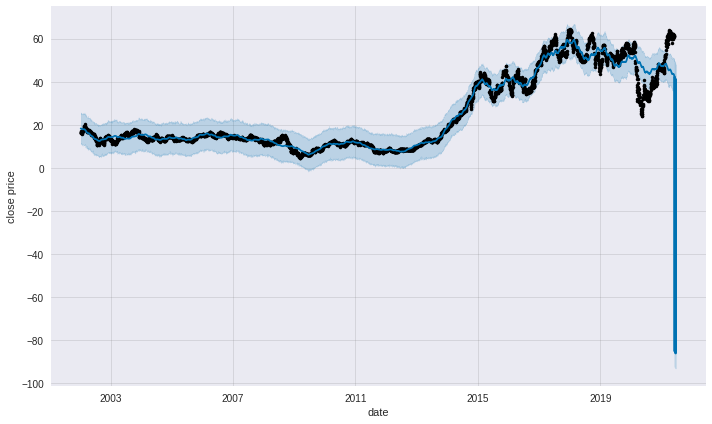

In [67]:
predict_fig = model2.plot(forecast_pd, xlabel='date', 
ylabel='close price')


Add Deep NN model here:  See Python for Algo Trading for references
